# Transformer for time-series problem

https://arxiv.org/abs/1706.03762 <br>
https://www.tensorflow.org/tutorials/text/transformer <br>
Pytorch version will come soon <br>



In [3]:

import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.model_selection import train_test_split 
import time
import numpy as np
import matplotlib.pyplot as plt
import gc

In [2]:
# Calculate scaled dot product: q k v

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # calculate attention weight:
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # Attention (q.k.v)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights



def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
      
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)




    # some temporary weights:


if True:
    np.set_printoptions(suppress=True)

    temp_k = tf.constant([[10,0,0],
                          [0,10,0],
                          [0,0,10],
                          [0,0,10]], dtype=tf.float32)  # (4, 3)

    temp_v = tf.constant([[   1,0],
                          [  10,0],
                          [ 100,5],
                          [1000,6]], dtype=tf.float32)  # (4, 2)
    temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
    print_out(temp_q, temp_k, temp_v)




Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [3]:
# Multi-head Attention:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights
    
    
        
        
# check our Multi-head attention:

# change d to smaller
n_d_model=16


temp_mha = MultiHeadAttention(d_model=n_d_model, num_heads=8)
y = tf.random.uniform((1, 60, n_d_model))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape
    
# Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape
    
    




TensorShape([64, 50, 512])

In [4]:
class EncoderLayer(tf.keras.layers.Layer):
    # Here we use a 0.1 dropout rate as default
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2
        
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2



In [5]:

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

#pos_encoding = positional_encoding(50, 512)
#print (pos_encoding.shape)



class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)
    
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    


In [4]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [7]:
sample_transformer = Transformer(
    num_layers=2, d_model=16, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [8]:
sample_transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  273504    
_________________________________________________________________
decoder (Decoder)            multiple                  267744    
_________________________________________________________________
dense_38 (Dense)             multiple                  136000    
Total params: 677,248
Trainable params: 677,248
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'Train Step')

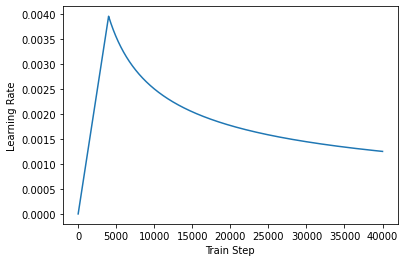

In [9]:
# Optimizor
d_model = 16
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Learning rate curve:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [10]:
# loss and metric
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [11]:
# Load data:
import pandas as pd
root_path = "Data/Ant_202007/fusion.csv"
df = pd.read_csv(root_path)
names_array = df.keys()[2:]
names_array = list(names_array)
df.head()

from sklearn import preprocessing
# Prepare data:
index_name = 0
n_bins = 10000
min_val = np.nanmin(df[names_array[index_name]])
max_val = np.nanmax(df[names_array[index_name]])
n_per = (max_val-min_val)/n_bins
df[names_array[index_name]] = (df[names_array[index_name]]-min_val)//n_per


delta_t = 60*2
BATCH_SIZE = 64

"""

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)



"""
X = np.zeros((df.shape[0]-delta_t,delta_t,5),dtype=float)


# 
y = df[names_array[index_name]][delta_t:]
    
for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df[i:i+delta_t][names_array].values

print("Finish preparing data")




Prepare data 0.00 percent
Prepare data 24.01 percent
Prepare data 48.03 percent
Prepare data 72.04 percent
Prepare data 96.06 percent
Finish preparing data


In [12]:
# Here we only use one dimension in x
X = X[:,:,index_name]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

train_dataset = train_dataset.shuffle(buffer_size=1024*8).batch(BATCH_SIZE)



In [13]:

# Hyper parameteres:

num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = int(max(df[names_array[index_name]]))+2
target_vocab_size = int(max(df[names_array[index_name]]))+2
dropout_rate = 0.1




In [14]:
# Transformer
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [15]:
# MASK
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask



In [16]:


# check point
checkpoint_path = "./TFT/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
EPOCHS = 20

# Set to be int64
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)


    





In [17]:
# Train
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    set
        tar = tf.reshape(tar,(-1,1))
        # convert to int64
        inp = tf.cast(inp,dtype=tf.int64)
        tar = tf.cast(tar,dtype=tf.int64)
        

        train_step(inp, tar)
    
        if batch % 200 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, 
                                                                          train_loss.result(), train_accuracy.result()))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
        
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
        




Epoch 1 Batch 0 Loss nan Accuracy 0.0000
Epoch 1 Batch 200 Loss nan Accuracy 0.0000
Epoch 1 Batch 400 Loss nan Accuracy 0.0000
Epoch 1 Loss nan Accuracy 0.0000
Time taken for 1 epoch: 63.91315269470215 secs

Epoch 2 Batch 0 Loss nan Accuracy 0.0000
Epoch 2 Batch 200 Loss nan Accuracy 0.0000
Epoch 2 Batch 400 Loss nan Accuracy 0.0000
Epoch 2 Loss nan Accuracy 0.0000
Time taken for 1 epoch: 49.487326860427856 secs

Epoch 3 Batch 0 Loss nan Accuracy 0.0000
Epoch 3 Batch 200 Loss nan Accuracy 0.0000
Epoch 3 Batch 400 Loss nan Accuracy 0.0000
Epoch 3 Loss nan Accuracy 0.0000
Time taken for 1 epoch: 49.491544008255005 secs

Epoch 4 Batch 0 Loss nan Accuracy 0.0000
Epoch 4 Batch 200 Loss nan Accuracy 0.0000
Epoch 4 Batch 400 Loss nan Accuracy 0.0000
Epoch 4 Loss nan Accuracy 0.0000
Time taken for 1 epoch: 49.54981732368469 secs

Epoch 5 Batch 0 Loss nan Accuracy 0.0000
Epoch 5 Batch 200 Loss nan Accuracy 0.0000
Epoch 5 Batch 400 Loss nan Accuracy 0.0000
Saving checkpoint for epoch 5 at ./TFT/

In [ ]:
# Test

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))

test_dataset = train_dataset.shuffle(buffer_size=1024*8).batch(BATCH_SIZE)

ans = []

for batch, (inp, tar) in enumerate(test_dataset):
    tar = tf.reshape(tar,(-1,1))
    # convert to int64
    inp = tf.cast(inp,dtype=tf.int64)
    tar = tf.cast(tar,dtype=tf.int64)
    fn_out, _ = sample_transformer(inp, tar, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)
    ans.extend(np.array(fn_out).ravel())






array([ 0.10617172, -0.07797275,  0.03969153, ...,  0.00255264,
        0.09376192,  0.03280225], dtype=float32)

In [ ]:
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 1), dtype=tf.int64, minval=0, maxval=200)


fn_out, _ = saple_transformer(temp_input, temp_target, training=True, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)